<div class="alert alert-info">
    
➡️ Before you start, make sure that you are familiar with the **[study guide](https://liu-nlp.ai/text-mining/logistics/)**, in particular the rules around **cheating and plagiarism** (found in the course memo).

➡️ If you use code from external sources (e.g. StackOverflow, ChatGPT, ...) as part of your solutions, don't forget to add a reference to these source(s) (for example as a comment above your code).

➡️ Make sure you fill in all cells that say **`YOUR CODE HERE`** or **YOUR ANSWER HERE**.  You normally shouldn't need to modify any of the other cells.

</div>

# L2: Text Classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of speeches with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

In [33]:
%matplotlib inline

## Dataset

The raw data for this lab comes from [The Riksdag’s Open Data](https://data.riksdagen.se/in-english/). We have preprocessed and tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [34]:
import pandas as pd
import bz2

with bz2.open('speeches-201718.json.bz2', mode='rt', encoding='utf-8') as source:
    speeches_201718 = pd.read_json(source, encoding='utf-8')

with bz2.open('speeches-201819.json.bz2', mode='rt', encoding='utf-8') as source:
    speeches_201819 = pd.read_json(source, encoding='utf-8')

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [35]:
speeches_201718.head()

,id,words,party
0,H5-002-004,eders majestäter eders kungliga högheter herr ...,S
1,H5-003-001,aktuell debatt om situationen för ensamkommand...,V
2,H5-003-002,herr talman och ledamöter jag vill börja med a...,S
3,H5-003-003,herr talman åhörare den här debatten handlar a...,M
4,H5-003-004,herr talman ansvar och rättssäkerhet är två or...,SD


Throughout the lab, we will be using the speeches from **2017/2018** as our **training data**, and the speeches from **2018/2019** as our **test data**.

In [36]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [37]:
parties = sorted(training_data['party'].unique())
print(parties)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']


## Problem 1: Data visualization

Let’s start by getting to know the data better by producing a simple visualization.  More specifically, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties.

_(If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election), but it’s not required for solving this lab.  Neither is knowing Swedish!)_

Your task is to **write code to generate two bar plots** that visualize the party distribution, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other; and
* to the results of the 2014 and the 2018 general elections.

To facilitate the comparison, you should plot the parties in descending order of their total number of speeches.

**_Note:_** You can produce the bar plots in any way you like (e.g. with Matplotlib, Seaborn, or directly with Pandas); if you don’t know where to start, one suggestion is to look at [seaborn’s tutorial for “visualizing categorical data”](https://seaborn.pydata.org/tutorial/categorical.html), specifically the parts about making _count_ plots.

In [38]:
# Importing seaborn style — usually a good choice by default
import seaborn as sns
sns.set()

/var/folders/6n/q_rng36s2vx21yvdlfr34pd40000gn/T/ipykernel_96068/1879978267.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(speeches_201718['party'].value_counts(), palette=colors)


<Axes: xlabel='party', ylabel='count'>

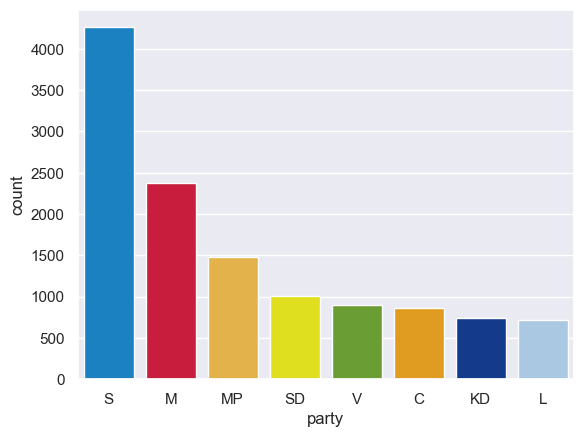

In [39]:

# to clearly seee how the party changes over time, define a color map for the parties

party_colors = {
    'S': '#0087DC',  
    'M': '#E4002B',        
    'MP': '#FDBB30', 
    'SD': '#FFFF00',
    'V': '#6AB023',
    'C': '#FFA500',
    'L': '#A2C8EC',
    'KD': '#0033A0',            
}
party_counts = speeches_201718['party'].value_counts()

colors = [party_colors[party] for party in party_counts.index]

sns.barplot(speeches_201718['party'].value_counts(), palette=colors)


/var/folders/6n/q_rng36s2vx21yvdlfr34pd40000gn/T/ipykernel_96068/2567754973.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(speeches_201819['party'].value_counts(), palette=colors)


<Axes: xlabel='party', ylabel='count'>

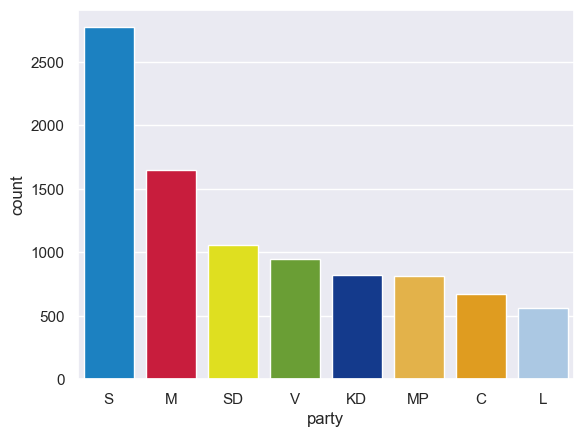

In [40]:
"""Produce a plot for the 2018/2019 speeches."""
party_counts = speeches_201819['party'].value_counts()

colors = [party_colors[party] for party in party_counts.index]
sns.barplot(speeches_201819['party'].value_counts(), palette=colors)

After you made the plots, **summarize your observations** very briefly in the cell below!

We could find that Swedish Social Democratic Party and Moderate Party dominant the Riksdag in these two elections due to the number of speeches, but the absoult number of speech number decreased significantly.

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data _(with simple token counts)_
2. instantiate and fit the Naive Bayes model on the training data
3. evaluate the model on the test data

You can use any approach you like, but a suggestion is to use scikit-learn’s convenience [Pipeline class](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [classification_report()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

**Write code to produce a Multinomial Naive Bayes classifier as described above and report its performance on the test data!**

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Build a pipeline: count vectorizer + Multinomial Naive Bayes
nb_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

# Fit on training data
nb_pipe.fit(training_data['words'], training_data['party'])

# Evaluate on test data
pred = nb_pipe.predict(test_data['words'])
print(classification_report(test_data['party'], pred, digits=4))

# Keep model variable for later cells (confusion matrix, grid search etc.)
model = nb_pipe

              precision    recall  f1-score   support

           C     0.6341    0.0387    0.0730       671
          KD     0.7000    0.0171    0.0333       821
           L     0.9167    0.0196    0.0385       560
           M     0.3585    0.6782    0.4691      1644
          MP     0.3623    0.2472    0.2939       809
           S     0.4598    0.8420    0.5948      2773
          SD     0.5690    0.1245    0.2043      1060
           V     0.5885    0.1505    0.2397       950

    accuracy                         0.4281      9288
   macro avg     0.5736    0.2647    0.2433      9288
weighted avg     0.5204    0.4281    0.3446      9288



Would you have expected the results that you got? (No need to write anything about this just yet, but make sure you understand what the values in the report mean.)

## Problem 3: Baselines

Evaluation metrics such as accuracy or F1-score should not be understood as _absolute_ measures of performance, but should be used only to _compare_ different classifiers. When other classifiers are not available, there are some simple baselines we can use that are implemented by scikit-learn’s [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html).

One of the simplest baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the _most frequent class_ baseline.

**Write code to fit the most-frequent-class baseline on the training data and report its performance on the test data!**

In [42]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(training_data['words'], training_data['party'])
dummy_clf.predict(test_data['words'])
dummy_clf.score(test_data['words'], test_data['party'])


0.298557278208441

A slightly more interesting baseline is a classifier that generates predictions by random sampling, while respecting the training set’s class distribution.  This way of random sampling is sometimes called _stratified sampling_.

**Write code to fit the random sampling baseline on the training data and report its performance on the test data!**

In [43]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(training_data['words'], training_data['party'])
dummy_clf.predict(test_data['words'])
dummy_clf.score(test_data['words'], test_data['party'])

0.17474160206718345

## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Your task here is to **implement undersampling to create a balanced subset of the training data**. Afterwards, **rerun the evaluation** from Problem&nbsp;2 on the balanced data and compare the results.

**_Hint:_** Your balanced subset should consist of 5,752 speeches.

In [55]:
"""Implement undersampling with the classifier from Problem 2 and report its performance on the test data."""
# We want a balanced subset of 5,752 speeches. There are 8 classes, so target is 719 per class (5752 / 8 = 719).
n_classes = training_data['party'].nunique()
target_per_class = 5752 // n_classes
# Create undersampled balanced training set: sample `target_per_class` from each party
balanced_train = training_data.groupby('party', group_keys=False).apply(lambda g: g.sample(n=target_per_class, random_state=42)).reset_index(drop=True)

# print('Balanced training set shape:', balanced_train.shape)
# print(balanced_train['party'].value_counts())

# Train a new Naive Bayes pipeline on the balanced data and evaluate on the original test set
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nb_pipe_bal = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

nb_pipe_bal.fit(balanced_train['words'], balanced_train['party'])
pred_bal = nb_pipe_bal.predict(test_data['words'])

print(pred_bal)
print(test_data['party'])

#clf = nb_pipe_bal['clf']



/var/folders/6n/q_rng36s2vx21yvdlfr34pd40000gn/T/ipykernel_96068/3723083266.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train = training_data.groupby('party', group_keys=False).apply(lambda g: g.sample(n=target_per_class, random_state=42)).reset_index(drop=True)


['S' 'MP' 'MP' ... 'S' 'M' 'S']
0        M
1        S
2        M
3        S
4       SD
        ..
9283     S
9284     M
9285     S
9286     M
9287     S
Name: party, Length: 9288, dtype: object


## Problem 5: Confusion matrix

A _confusion matrix_ is a type of table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with _gold-standard_ class $i$ was _predicted_ as belonging to class $j$.

In scitkit-learn, a simple way to visualize the confusion matrix as a _heatmap_ is to use [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).  The following cell demonstrates how to compute and display a confusion matrix for the classifier in the `model` variable — you may have to adjust this based on the code you have written for your previous solutions:

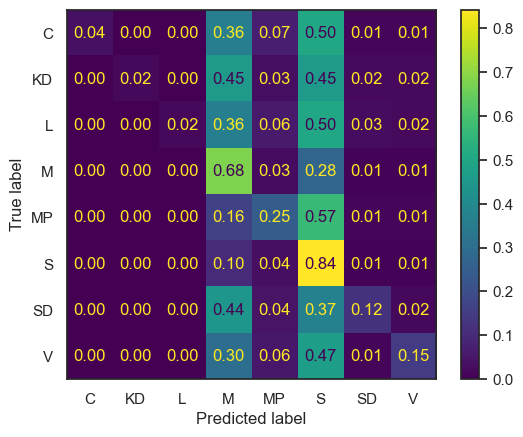

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

with sns.axes_style("white"):  # Seaborn’s default style doesn’t play well with ConfusionMatrixDisplay, so we change it temporarily
    ConfusionMatrixDisplay.from_estimator(
        model,                 # The model that you want to plot the confusion matrix for
        test_data['words'],    # The input data for the model
        test_data['party'],    # The correct (gold-standard) labels for the input data
        normalize='true',
        values_format='.2f'
    )

**Your task** is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.  You can read this off of the visualization above, but for the purposes of this exercise, we want to do this programmatically (i.e. with code).  For this, you most likely want to use the scikit-learn function [confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), which gives you the confusion matrix of a classifier.

**Write code that, for each party $p$, print the party most often confused with $p$ by the classifier from Problem 4!**

In [ ]:
from sklearn.metrics import confusion_matrix

def get_moist_confused_party(p):
    """Plot normalized confusion matrix for a given model and data."""
    nb_pipe_bal = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', MultinomialNB())])
    nb_pipe_bal.fit(balanced_train['words'], balanced_train['party'])
    pred_test_party = nb_pipe_bal.predict(test_data['words'])
    print(parties)
    confusion_mat = confusion_matrix(test_data['party'], pred_test_party,labels=parties)
    print(confusion_mat)
    p_index = parties.index(p)
    p_confusion_list = confusion_mat[p_index].tolist()
    # get the max and second max value
    p_sorted_confused_list = sorted(p_confusion_list,reverse=True)
    p_max_pred_number = p_sorted_confused_list[0]
    p_second_pred_number = p_sorted_confused_list[1]
    p_max_pred_index = p_confusion_list.index(p_max_pred_number)
    p_second_pred_index = p_confusion_list.index(p_second_pred_number)
    p_max_pred_party = parties[p_max_pred_index]
    p_second_pred_party = parties[p_second_pred_index]
    return p_second_pred_party if p == p_max_pred_party else p_max_pred_party
get_moist_confused_party("KD")
# get_moist_confused_party("M")
# get_moist_confused_party("C")

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']
[[305  61  45 100  38  21  46  55]
 [ 79 320  58 178  39  27  57  63]
 [ 52  51 245  60  29  19  38  66]
 [238 189 141 737  75  56 115  93]
 [ 72  63  53  94 305  95  44  83]
 [226 234 165 400 299 961 193 295]
 [108  98 121 158  28  24 438  85]
 [ 66  71  62 112  37  20  72 510]]


'M'

Before you move on, take a minute to reflect on whether your results make sense.

## Problem 6: Grid Search

Until now, you have been using the count-based vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find a combination of input representation, model, and hyperparameters that maximizes the performance for the task at hand.

Manually trying out many combinations of hyperparameters of a vectorizer–classifier pipeline can be cumbersome. However, scikit-learn provides functionality for [performing **grid search**](https://scikit-learn.org/stable/modules/grid_search.html), which is the name for an exhaustive search for the best hyperparameters over a _grid_ of possible values.

When searching for the best hyperparameters, it’s important to _not_ run evaluations on the final test set.  Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation, which scikit-learn provides in the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class.  To use grid search, you need to know which parameters can be tuned and what they’re called; you can find this information by calling `get_params()` on your model pipeline:

In [83]:
# Replace "nb_pipe" with the variable that has your model pipeline, if necessary
nb_pipe.get_params()

{'memory': None,
 'steps': [('vect', CountVectorizer()), ('clf', MultinomialNB())],
 'transform_input': None,
 'verbose': False,
 'vect': CountVectorizer(),
 'clf': MultinomialNB(),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'clf__force_alpha': True}

Your task is to **find a pipeline that outperforms the model from Problem&nbsp;4** on _at least one_ of the aggregated evaluation metrics (accuracy, macro avg., or weighted avg. scores) on the test set, by performing **grid search with 5-fold cross-validation** on the training set.  Which hyperparameters you tune and what values you choose is up to you, as long as try at least _two different hyperparameters_ with at least _two different values_ each, and your resulting pipelines outperforms the one from Problem&nbsp;4.  However, here are some suggestions:

* In the vectorizer, you could try a _set-of-words_ (binary) model in addition to the default _bag-of-words_ model.
* In the vectorizer, you could try extracting bigrams and/or trigrams in addition to unigrams.
* In the Naive Bayes classifier, you could try to using different values for additive smoothing.

**Write code to perform grid search, then report the results of your best model, along with the parameter values that yielded these results.**

In [ ]:
# Grid search to find a pipeline that may outperform the balanced model (Problem 4).
# We tune at least two hyperparameters: vectorizer binary (set-of-words) and ngram range,
# and also try different smoothing (alpha) values for MultinomialNB.
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Base pipeline
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

# Parameter grid: try binary (set-of-words) vs counts, unigrams vs unigrams+bigrams, and different alpha
param_grid = {
    'vect__binary': [False, True],
    'vect__ngram_range': [(1,1), (1,2)],
    'clf__alpha': [1.0, 0.1]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

print('Starting grid search (this may take a minute) ...')
grid.fit(training_data['words'], training_data['party'])

print('\nGrid search done. Best cross-validation accuracy: {:.4f}'.format(grid.best_score_))
print('Best parameters:')
print(grid.best_params_)

# Evaluate best estimator on the test set
best = grid.best_estimator_
pred_best = best.predict(test_data['words'])
print('\nClassification report for best grid-search model on test set:\n')
print(classification_report(test_data['party'], pred_best, digits=4))

# Compute aggregated metrics for the best model
acc_best = accuracy_score(test_data['party'], pred_best)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(test_data['party'], pred_best, average='macro')
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(test_data['party'], pred_best, average='weighted')

best_metrics = {
    'accuracy': acc_best,
    'precision_macro': prec_macro,
    'recall_macro': rec_macro,
    'f1_macro': f1_macro,
    'precision_weighted': prec_w,
    'recall_weighted': rec_w,
    'f1_weighted': f1_w
}

# For a fair comparison to Problem 4, (re)train the undersampled balanced model here and evaluate it on the test set
# Balanced sampling: 5752 total -> 719 per class (assuming 8 classes)
n_classes = training_data['party'].nunique()
target_per_class = 5752 // n_classes
balanced_train = training_data.groupby('party', group_keys=False).apply(lambda g: g.sample(n=target_per_class, random_state=42)).reset_index(drop=True)

nb_pipe_bal = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())])
nb_pipe_bal.fit(balanced_train['words'], balanced_train['party'])
pred_bal = nb_pipe_bal.predict(test_data['words'])
print('\nClassification report for balanced (undersampled) model on test set:\n')
print(classification_report(test_data['party'], pred_bal, digits=4))

acc_bal = accuracy_score(test_data['party'], pred_bal)
prec_macro_b, rec_macro_b, f1_macro_b, _ = precision_recall_fscore_support(test_data['party'], pred_bal, average='macro')
prec_w_b, rec_w_b, f1_w_b, _ = precision_recall_fscore_support(test_data['party'], pred_bal, average='weighted')

bal_metrics = {
    'accuracy': acc_bal,
    'precision_macro': prec_macro_b,
    'recall_macro': rec_macro_b,
    'f1_macro': f1_macro_b,
    'precision_weighted': prec_w_b,
    'recall_weighted': rec_w_b,
    'f1_weighted': f1_w_b
}

# Print comparison of aggregated metrics
print('\nAggregated metric comparison (best_grid vs balanced_model):')
for k in ['accuracy','f1_macro','f1_weighted','precision_macro','precision_weighted']:
    print(f"{k}: grid={best_metrics[k]:.4f}  |  balanced={bal_metrics[k]:.4f}")

# Save best estimator into variables for downstream cells if desired
nb_pipe = best
model = best

# Also keep balanced training data and model available
balanced_training_data = balanced_train
balanced_model = nb_pipe_bal


## Individual reflection

<div class="alert alert-info">
    <strong>After you have solved the lab,</strong> write a <em>brief</em> reflection (max. one A4 page) on the question(s) below.  Remember:
    <ul>
        <li>You are encouraged to discuss this part with your lab partner, but you should each write up your reflection <strong>individually</strong>.</li>
        <li><strong>Do not put your answers in the notebook</strong>; upload them in the separate submission opportunity for the reflections on Lisam.</li>
    </ul>
</div>

In this lab, you have produced evaluation reports for a total of five classifiers:

- two baselines (most frequent class & random sampling)
- Naive Bayes with default values and unbalanced data
- Naive Bayes with default values and undersampled data
- the best-performing pipeline from your grid search

How do you interpret these evaluation reports, i.e., what do they mean for the usefulness of each classifier? What conclusion do you draw from these results? Refer to specific evaluation scores that you find particularly relevant for your argument.

**Congratulations on finishing this lab! 👍**

<div class="alert alert-info">
    
➡️ Before you submit, **make sure the notebook can be run from start to finish** without errors.  For this, _restart the kernel_ and _run all cells_ from top to bottom. In Jupyter Notebook version 7 or higher, you can do this via "Run$\rightarrow$Restart Kernel and Run All Cells..." in the menu (or the "⏩" button in the toolbar).

</div>